In [2]:
# !pip3 install two-sample-binomial
# !pip3 install multiple-hypothesis-testing

from twosample import binom_test
from multitest import MultiTest

import numpy as np
import scipy


import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] =  [8, 6]
mpl.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm

from scipy.stats import poisson, binom, norm, hypergeom, uniform

import pandas as pd

from sample_survival_data import *

In [3]:
#!pip3 install --upgrade multiple-hypothesis-testing

## Findings: (4/8/2022):
 - With $T=100$ and non stable HC, we get ~ 10 new discoveries with HC for genes in the range 100-200
 - About 3 of which relies on 2 P-values (the rest on one) (sparsity, 0.01 - 0.02)
 - To do: 1) try the entire range 2) try larger Ts

## Duscussion:
 - Simulate null of HC and log-rank: shuffle responses vector of each gene -- done
 - Biological intepertation
 - Try merging time stamps -- works


## Data:
- Min HypGeom 
- Look for data.
    - SCANB ~ 3000 patients ~1000 unique time points
    - Keywords: dose response curve,
    - Perhaps survival of flies
- 

In [216]:
from survival import ( hypergeom_test, q95)

def log_rank_test(Nt1, Nt2, Ot1, Ot2, alternative='two-sided'):
    """
    log-rank test 
    We assume that len(Nt1) == len(Nt2), and that each
    entry in either list represents an event in which
    a change occurs in the number of items in each groups 
    (the change in each group may also be zero)
    
    Args:
    -----
    :Nt1:   vector of counts in group 1 (each count corresponds to an event)
    :Nt2:   vector of counts in group 2 
    :alternative:   options are: 'greater', 'less', or 'two-sided'
                    with 'greater', test against the alternative that
                    more events occured in Nt2 compared to Nt1
    Returns:
    -------
    :z:       z score of the log-rank test
    :pvalue:  P-value
    """

    assert (len(Nt1) == len(Nt2))
    assert (len(Ot1) == len(Ot2))
    assert (len(Ot1) == len(Nt1))
    
    Nt = Nt2 + Nt1
    e0 = Nt2 * (Ot1 + Ot2) / Nt
    var0 = e0 * ((Nt - (Ot1 + Ot2)) / Nt) * (Nt1 / (Nt - 1))

    z = np.sum(Ot2 - e0) / np.sqrt(np.sum(var0))

    if alternative == 'greater':
        pval = norm.sf(z)
    elif alternative == 'less':
        pval = norm.cdf(z)
    else:
        pval = 2 * norm.cdf(-np.abs(z))

    return z, pval


In [5]:
def multi_pvals(Nt1, Nt2, Ot1, Ot2, test='hypergeom',
                randomize=False, alternative='greater'):
    """
    Compute P-values from the pair list of coutns in the two groups.
    We have one p-value per event time.
    An even is a pair (Nt1[i], Nt2[i]).
    
    Args:
    -----
    :Nt1:   vector of counts in group 1 (each count corresponds to an event)
    :Nt2:   vector of counts in group 2
    :test:  is the type of test to apply (options are: 'hypergeom' or
     'binomial')
    :randomize:  randomized individual tests or not
    :alternative:   type of alternative to use in each test 

    Return:
        P-values 
    """

    assert (len(Nt1) == len(Nt2))
    assert (len(Ot1) == len(Ot2))
    assert (len(Ot1) == len(Nt1))

    Nt = Nt2 + Nt1

    if test == 'binomial':
        n = Ot1 + Ot2
        p = Nt2 / Nt
        x = Ot2
        pvals = binom_test(x, n, p, randomize=randomize, alt=alternative)
    elif test == 'hypergeom':
        pvals = hypergeom_test(Ot2, Nt, Nt2, Ot1 + Ot2,
                               randomize=randomize, alternative=alternative)

    return pvals


In [6]:

def evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, stbl=True, gamma=.4, randomize=False):
    """
    Args:
    :Nt1: first list of events
    :Nt2: second list of events
    
    Compute several statistics of the two-sample data:
    log-rank
    higher criticism
    Fisher combination test
    minimum P-value
    Berk-Jones
    FDR
    """
    
    lr, lr_pval = log_rank_test(Nt1, Nt2, Ot1, Ot2)
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=randomize)
    mt = MultiTest(pvals[pvals < 1], stbl=stbl) # if not using stbl=False, then sometimes
                                      # HC misses the significance of the strongest effect 
    
    return {'Logrank': np.abs(lr),
            'HC': mt.hc(gamma=gamma)[0],
            'Fisher': mt.fisher(),
            'minP': mt.minp(),
            'BJ': mt.berk_jones(gamma=.45),
            #'FDR': mt.fdr()[0],
            #'wilcoxon': -np.log(1e-20 + scipy.stats.ranksums(Nt1, Nt2).pvalue),
           }

## Load Data:

In [7]:
#df = pd.read_csv("./Data/Gene_expression_data/AML_Bull.csv")
df = pd.read_csv("./Data/data.csv")
gene_names = [c for c in df.columns if c not in ['Unnamed: 0', 'time', 'event']]

In [789]:
def arrange_group(dfg):
    """
    Group events in time; Find group size in each 
    time sample
    """
    
    dft = dfg#.groupby('time').sum()
    dft = dft.sort_values('time').reset_index()
    dft['total'] = len(dft)
    dft['dead'] = dft.event
    dft['cum_dead'] = dft.dead.cumsum()
    
    # dft['censored'] = (~dft.event).cumsum()
    # incorporate censorship. Change to 'at-risk'
    dft['cum_censored'] = (dft.event == 0).cumsum()
    dft['censored'] = (dft.event == 0) + 0.0
    dft['at-risk'] = dft['total']
    dft.loc[1:,'at-risk'] = dft['total'].max() - dft[:-1]['cum_dead'].values - dft['cum_censored'].values[1:]
    dft = dft.groupby('time').max()
    assert(np.all(-np.diff(dft['at-risk']) >= dft['dead'].values[:-1]))
    return dft

def two_groups_gene(data, gene_name):
    """
    Arranges relevant data in a two groups format
    for survival analysis based on the examined gene
    
    Args:
    :data:   is a dataframe with :gene_name: as one of its columns.
             additional columns are :time: and :event:
             
    Return:
        dataframe indexed by time and number of survived elements in
        each group
    
    """
    
    dfg = data[[gene_name,'time', 'event']]
    idc_split = dfg[gene_name] >= 1    
    df1 = arrange_group(dfg[idc_split])
    df2 = arrange_group(dfg[~idc_split])
    
    dfm = df1[['at-risk', 'dead', 'censored', 'total']].join(df2[['at-risk', 'dead', 'censored', 'total']], lsuffix='1', rsuffix='2', how='outer')
    dfm['dead1'] = dfm['dead1'].fillna(0)
    dfm['dead2'] = dfm['dead2'].fillna(0)
    dfm['censored1'] = dfm['censored1'].fillna(0)
    dfm['censored2'] = dfm['censored2'].fillna(0)
    dfm['total1'] = dfm['total1'].fillna(method = 'bfill').fillna(method='ffill')
    dfm['total2'] = dfm['total2'].fillna(method = 'bfill').fillna(method='ffill')
    
    dfm['at-risk1'] = dfm['total1']
    dfm['at-risk2'] = dfm['total2']    
    dfm.loc[dfm.index[1:],'at-risk1'] = dfm['total1'].values[0] - dfm['dead1'].cumsum().values[:-1] - dfm['censored1'].cumsum().values[:-1]
    dfm.loc[dfm.index[1:],'at-risk2'] = dfm['total2'].values[0] - dfm['dead2'].cumsum().values[:-1] - dfm['censored2'].cumsum().values[:-1]

    #dfm['at-risk2'] = dfm['at-risk2'].max() - dfm['dead2'].cumsum() - dfm['censored2'].cumsum()
    #dfm['at-risk2'] = dfm['at-risk2'].fillna(method='bfill')
    
    return dfm


def reduce_time_resolution(df, T):
    """
    Group together events in surivial data
    across uniform time intervals. 
    
    Args:
    :df: original dataset. Index represent time of events
    :T:  maximal number of time intervals
    
    """
    
    Tmin = df.index.min()
    Tmax = df.index.max()
    tt = np.linspace(Tmin, Tmax, T+1)
    dfc = pd.DataFrame()
    for t_down, t_up in zip(tt[:-1], tt[1:]):
        dft = df[(t_down <= df.index) & (df.index < t_up)]
        r = dft.sum()[['dead1', 'dead2', 'censored1', 'censored2']]
        r['at-risk1'] = dft['at-risk1'].max()
        r['at-risk2'] = dft['at-risk2'].max()
        dfc = dfc.append(r, ignore_index=True)
    return dfc.fillna(method='backfill').dropna()

In [858]:
from real_data import test_gene

In [859]:

def simulate_null_data(data, T, rep = 1, stbl=True):
    """
    Generate random group assignments. 
    Evaluate test statistics. 

    """
    
    df0 = pd.DataFrame()
    gene_names = [c for c in df.columns if c not in ['Unnamed: 0', 'time', 'event']]
    
    print(f"Simulating null by permuting labels. Using {rep} iterations")
    
    for _ in range(rep):
        print("Sampling a random division...")
        df_copy = df.copy()
        df_copy.iloc[:, 1:-2] = np.random.randint(2, size = df.iloc[:, 1:-2].shape)
        print(f"Testing {len(gene_names)} 'null' genes...")
        for gene_name in tqdm(gene_names): 
            res = test_gene(df_copy, gene_name, T, stbl=stbl)
            df0 = df0.append(res, ignore_index=True)

    # critical values under the null:
    return df0


## Report null values

In [915]:

def infmean(x):
    return np.mean(np.ma.masked_invalid(x))

def std_95(x):
    return scipy.stats.mstats.mjci(x, prob = [0.95])[0]

def infstd(x):
    return np.std(np.ma.masked_invalid(x))


def report_null_stats(df0, T, precision=5):
    dsp = df0.agg([q95, 'mean', 'std', stdn]).filter(
        ['log_rank_greater', 'hc_greater', 'x0', 'y0', 'lam1', 'lam2'])
    dsp.loc['std_95'] = [std_95(df0[c]) for c in dsp]

    print(np.round(dsp, precision))

    if 'lam1' in dsp:
        m = (infmean(df0['lam1']) + infmean(df0['lam1']))/2
        s = np.sqrt((infstd(df0['lam1']) ** 2 + infstd(df0['lam2']) ** 2) / 2)
        print("lam * T = ", np.round(m * T, precision))
        print("SE(lam*T) = ", np.round(s * T, precision))

T = 100
M=1
stbl = True
df0 = pd.read_csv(f'results/SCNAB_null_{stbl}_T{T}_M{M}.csv')

report_null_stats(df0, T)

        log_rank_greater  hc_greater          x0          y0     lam1     lam2
q95              1.87927    -0.41647  1579.10000  1580.00000  0.00880  0.00880
mean             0.76475    -1.90082  1534.77946  1534.22054  0.00846  0.00846
std              0.57825     0.94700    27.47489    27.47489  0.00020  0.00020
stdn             0.00601     0.00984     0.28552     0.28552  0.00000  0.00000
std_95           0.02036     0.01454     0.62031     0.65885  0.00000  0.00001
lam * T =  0.8464
SE(lam*T) =  0.01984


/usr/local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:616: RuntimeWarning: underflow encountered in _beta_cdf
  return _boost._beta_cdf(x, a, b)
/usr/local/lib/python3.8/site-packages/numpy/ma/core.py:851: RuntimeWarning: underflow encountered in double_scalars
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


In [916]:
df0.hc_greater.max()

1.4087934171531438

In [412]:
# stat per gene
gene_names = df0.name.unique()

acc = []
dfr = pd.DataFrame()
for c in tqdm(df0.groupby('name')):
    dfr = dfr.append({
        'name': c[0],
        'q95': pd.Series.quantile(c[1].hc_greater, .95),
        'hc_mean': c[1].hc_greater.mean(),
        'hc_std': c[1].hc_greater.std(),
        'q95_log_rank': pd.Series.quantile(c[1].log_rank_greater, .95),
    }, ignore_index=True)


100%|██████████| 9259/9259 [00:25<00:00, 364.69it/s]


In [717]:
T = 100
M=1
stbl = False
df0 = pd.read_csv(f'results/SCNAB_null_False_T{T}_M{M}.csv')

crit_vals = df0.agg([q95]).filter(
        ['log_rank_greater', 
         'hc_greater', 
         'hc_greater_rev', 
         'log_rank_greater_rev'])
crit_vals

,log_rank_greater,hc_greater,hc_greater_rev,log_rank_greater_rev
q95,1.85544,-0.421011,-0.42719,1.85544


In [205]:
# here we go over all genes:

res = pd.DataFrame()
for gene_name in tqdm(gene_names[:100]):
   # try:
    r = test_gene(df, gene_name, T)
    res = res.append(r, ignore_index=True)
   # except:
        #print(f"Error in evaluating {gene_name}")
res

3.4518187080745752

In [901]:
T = 100
stbl = True
res = pd.read_csv(f"results/SCNAB_{stbl}_T{T}.csv")

In [902]:
crit_vals

,log_rank_greater,hc_greater,hc_greater_rev,log_rank_greater_rev
q95,1.85544,-0.421011,-0.42719,1.85544


In [917]:
# analyze results


def empirical_pval(x, stat_name, df0):
    return np.minimum((np.sum(df0[stat_name].values >= x) ) / len(df0), 1)

LRt = 1.68
HCt = 1.408
HCp = crit_vals.loc['q95', 'hc_greater']

log_rank_0 = (res.log_rank_greater <= LRt) & (res.log_rank_greater_rev <= LRt)
log_rank_1 = (res.log_rank_greater > LRt) | (res.log_rank_greater_rev > LRt)

hc_0 = (res.hc_greater <= HCt) & (res.hc_greater_rev <= HCp)
hc_1 = ((res.hc_greater > HCt) & (res.hc_greater_rev < HCp)) | ((res.hc_greater < HCp) & (res.hc_greater_rev > HCt))
#hc_1 = (res.hc_greater > HCt) | (res.hc_greater_rev > HCt)

resi = res[log_rank_0 & hc_1]
resi = res[log_rank_1 & hc_1]
resi

print("Discoverable by HC and LR: ", np.sum(log_rank_1 & hc_1))
print("Discoverable by HC but not LR: ", np.sum(log_rank_0 & hc_1))
print("Discoverable by LR but not HC: ", np.sum(log_rank_1 & hc_0))
print("Discoverable by neither LR nor HC: ", np.sum(log_rank_0 & hc_0))


Discoverable by HC and LR:  47
Discoverable by HC but not LR:  12
Discoverable by LR but not HC:  4007
Discoverable by neither LR nor HC:  4496


In [918]:
res['log_rank_pval'] = [empirical_pval(v, 'log_rank_greater', df0) for v in res['log_rank_greater'].values]
res['log_rank_rev_pval'] = [empirical_pval(v, 'log_rank_greater_rev', df0) for v in res['log_rank_greater_rev'].values]
res['hc_greater_pval'] = [empirical_pval(v, 'hc_greater', df0) for v in res['hc_greater'].values]
res['hc_greater_rev_pval'] = [empirical_pval(v, 'hc_greater_rev', df0) for v in res['hc_greater_rev'].values]
res['hc_pval'] = np.minimum(res['hc_greater_pval'], res['hc_greater_rev_pval'])
res['log_rank_pval'] = np.minimum(res['log_rank_pval'], res['log_rank_rev_pval'])
res['l-ratio'] = res['hc_pval'] / res['log_rank_pval']

In [919]:
resi = res[log_rank_0 & hc_1].sort_values('l-ratio').filter(['name', 'hc_greater', 'hc_greater_rev',
                                            'log_rank_greater', 'log_rank_greater_rev',
                                            'hc_pval', 'log_rank_pval', 'l-ratio'
                                           ])
len(resi)

12

In [920]:
remote_dir = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/Figs/"

In [928]:
def find_changes(Nt1, Nt2, Ot1, Ot2, stbl=True, gamma=.5):
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    mt = MultiTest(pvals[pvals<=1], stbl=stbl) 
    hc, hct = mt.hc(gamma=gamma)
    return pvals <= hct


def illustrate_survival_curve(df, gene_name, T, stbl=False):
    dfg = reduce_time_resolution(two_groups_gene(df, gene_name), T)
    
    Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
    Ot1, Ot2 = dfg['dead1'].values, dfg['dead2'].values
    
    stats = evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, stbl=stbl, randomize=False)
    stats_rev = evaluate_test_stats(Nt2, Nt1, Ot2, Ot1, stbl=stbl, randomize=False)
    
    if stats['hc_greater'] < stats_rev['hc_greater']: # reverse groups
        print("reversing roles of x and y...")
        dfg = dfg.rename(columns={'at-risk1': 'at-risk2', 'at-risk2': 'at-risk1', 
                         'dead1': 'dead2', 'dead2': 'dead1',
                        'censored1': 'censored2', 'censored2': 'censored1'
                                 })
        temp = stats
        stats = stats_rev
        stats_rev = temp
        
    
    Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
    Ot1, Ot2 = dfg['dead1'].values, dfg['dead2'].values
    
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    pvals_rev = multi_pvals(Nt2, Nt1, Ot2, Ot1, randomize=False)
    mt = MultiTest(pvals[pvals<1], stbl=stbl) 
    hc, hct = mt.hc(gamma=.2)
    #print("HC = ", hc)
    fpval = find_changes(Nt1, Nt2, Ot1, Ot2,
                         stbl=stbl)
    
    dfg['pvalue'] = pvals
    dfg['pvalue_rev'] = pvals_rev
    cumc1 = dfg['censored1'].cumsum()
    cumc2 = dfg['censored2'].cumsum()
    dfg['Survival Proportion X'] = (dfg['at-risk1'] - dfg['censored1']) / (dfg['at-risk1'].max() - cumc1)
    dfg['Survival Proportion Y'] = (dfg['at-risk2'] - dfg['censored2']) / (dfg['at-risk2'].max() - cumc2)
    #dfg['censored1'] = dfg['at-risk1'] - dfg['']
        
    
    df_disp = dfg[fpval].rename(columns={'at-risk1' : 'at-risk X', 'at-risk2' : 'at-risk Y',
                                     'dead1' : 'events X', 'dead2' : 'events Y'
                                    })
    
    plt.step(dfg.index, dfg['Survival Proportion X'], 'b', where='pre')
    plt.step(dfg.index, dfg['Survival Proportion Y'], 'r', where='pre')
    ct1 = dfg['censored1'] > 0
    ct2 = dfg['censored2'] > 0
    s1 = 10 * (dfg.loc[ct1, 'censored1'].max() / dfg.loc[ct1, 'censored1']).values
    s2 = 10 * (dfg.loc[ct2, 'censored2'].max() / dfg.loc[ct2, 'censored2']).values
    plt.scatter(dfg.index[ct1], dfg.loc[ct1,'Survival Proportion X'],
                marker='+', c='b',
                s=s1, alpha=.5)
    plt.scatter(dfg.index[ct2], dfg.loc[ct2,'Survival Proportion Y'],
                marker='+', c='r',
                s=s2, alpha=.5)
    
    plt.legend([r'$\hat{S}_x$', r'$\hat{S}_y$'], fontsize=16, loc=1)
    
    plt.bar(dfg.index[:len(fpval)], fpval, color='k', alpha=.2, width=.5)
    hc_pval = empirical_pval(stats['hc_greater'], 'hc_greater', df0)
    hc_pval_rev = empirical_pval(stats_rev['hc_greater'], 'hc_greater', df0)
    logrank_pval = empirical_pval(stats['log_rank_greater'], 'log_rank_greater', df0)

    st_HC = r"$\hat{p}(\mathrm{HC})$"
    st_HC_rev = r"$\hat{p}(\tilde{\mathrm{HC}})$"
    st_LR = r"$\hat{p}(\mathrm{LR})$"
    plt.title(rf"{gene_name}: {st_HC}={np.round(hc_pval,2)}, {st_HC_rev}={np.round(hc_pval_rev,2)}, {st_LR}={np.round(logrank_pval,2)}")
    #plt.title(f"{gene_name}, (HC={np.round(stats['hc_greater'],2)}, Log-rank={np.round(stats['log_rank_greater'],2)})")
    plt.ylabel('Survival Proportion', fontsize=16)
    plt.xlabel(r'$t$ (Time)', fontsize=16)
    
    return df_disp, dfg
    

/usr/local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:616: RuntimeWarning: underflow encountered in _beta_cdf
  return _boost._beta_cdf(x, a, b)


reversing roles of x and y...


/usr/local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:616: RuntimeWarning: underflow encountered in _beta_cdf
  return _boost._beta_cdf(x, a, b)


reversing roles of x and y...
reversing roles of x and y...


/usr/local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:616: RuntimeWarning: underflow encountered in _beta_cdf
  return _boost._beta_cdf(x, a, b)


reversing roles of x and y...


/usr/local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:616: RuntimeWarning: underflow encountered in _beta_cdf
  return _boost._beta_cdf(x, a, b)


reversing roles of x and y...
reversing roles of x and y...
reversing roles of x and y...


/usr/local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:616: RuntimeWarning: underflow encountered in _beta_cdf
  return _boost._beta_cdf(x, a, b)


reversing roles of x and y...


/usr/local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:616: RuntimeWarning: underflow encountered in _beta_cdf
  return _boost._beta_cdf(x, a, b)


reversing roles of x and y...


/usr/local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:616: RuntimeWarning: underflow encountered in _beta_cdf
  return _boost._beta_cdf(x, a, b)


reversing roles of x and y...


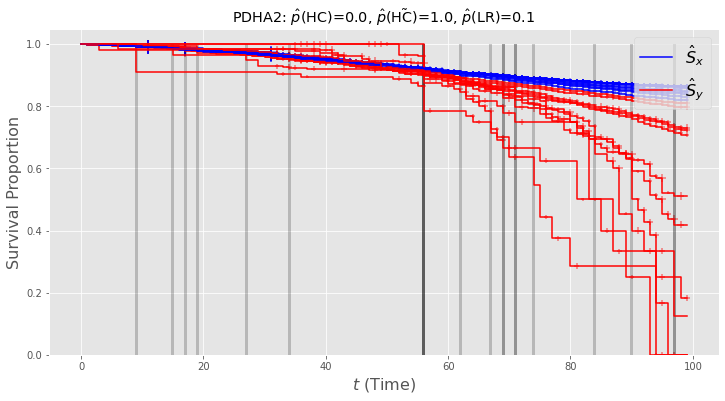

In [929]:
plt.rcParams['figure.figsize'] =  [12, 6]

ls_rep = []
for r in resi.iterrows():
    gene_name = r[1]['name']
    dfp, dfg = illustrate_survival_curve(df, gene_name, T, stbl=True)
    if len(dfp) > 2:
        ls_rep += [r[1]['name']]

reversing roles of x and y...


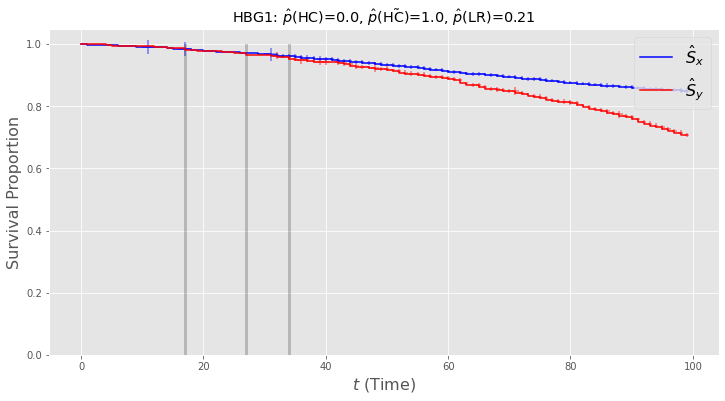

/usr/local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:616: RuntimeWarning: underflow encountered in _beta_cdf
  return _boost._beta_cdf(x, a, b)


reversing roles of x and y...


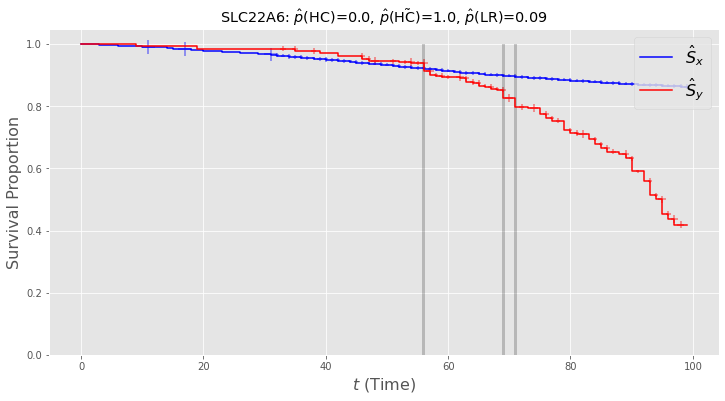

In [930]:
plt.rcParams['figure.figsize'] =  [12, 6]

for gene_name in ls_rep:
    df_disp, dfp = illustrate_survival_curve(df, gene_name, T, stbl=True)
    plt.savefig(remote_dir + gene_name + ".png")
    plt.show()

    dfd = df_disp.copy()
    dfd = dfd.iloc[:, :-2]

    for tag in ['pvalue', 'pvalue_rev']:
        dfd[tag] = np.round(dfd[tag],3)

    for tag in ['at-risk X', 'at-risk Y', 'events X', 'events Y']:
        dfd[tag] = dfd[tag].astype(int)

    dfd.index.name = 'time'

    rm_dir = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/csv/"
    dfd.to_csv(rm_dir + f'{gene_name}.csv')


In [932]:
dfp[80:100]

,at-risk2,at-risk1,censored2,censored1,dead2,dead1,pvalue,pvalue_rev,Survival Proportion X,Survival Proportion Y
80,51.0,2010.0,4.0,12.0,0.0,2.0,1.0,0.951110,0.884462,0.723077
81,47.0,1996.0,2.0,16.0,0.0,0.0,1.0,1.000000,0.882746,0.714286
82,45.0,1980.0,1.0,16.0,0.0,1.0,1.0,0.977778,0.881904,0.709677
83,44.0,1963.0,0.0,15.0,0.0,1.0,1.0,0.978077,0.880651,0.709677
84,44.0,1947.0,3.0,18.0,0.0,2.0,1.0,0.956279,0.879216,0.694915
85,41.0,1927.0,3.0,12.0,0.0,1.0,1.0,0.979167,0.877635,0.678571
86,38.0,1914.0,2.0,12.0,0.0,0.0,1.0,1.000000,0.876498,0.666667
87,36.0,1902.0,2.0,12.0,0.0,2.0,1.0,0.963184,0.875811,0.653846
88,34.0,1888.0,0.0,13.0,0.0,0.0,1.0,1.000000,0.874126,0.653846
89,34.0,1875.0,1.0,16.0,0.0,0.0,1.0,1.000000,0.873180,0.647059


In [872]:
dfp

,at-risk2,at-risk1,censored2,censored1,dead2,dead1,pvalue,pvalue_rev,Survival Proportion X,Survival Proportion Y
0,141.0,2928.0,0.0,0.0,0.0,1.0,1.0,0.954057,1.000000,1.000000
1,141.0,2927.0,0.0,0.0,0.0,2.0,1.0,0.910181,0.999658,1.000000
2,141.0,2925.0,0.0,0.0,0.0,0.0,1.0,1.000000,0.998975,1.000000
3,141.0,2925.0,0.0,0.0,0.0,3.0,1.0,0.868242,0.998975,1.000000
4,141.0,2922.0,0.0,0.0,0.0,3.0,1.0,0.868119,0.997951,1.000000
...,...,...,...,...,...,...,...,...,...,...
95,19.0,1785.0,1.0,13.0,0.0,0.0,1.0,1.000000,0.867352,0.500000
96,18.0,1772.0,3.0,14.0,0.0,0.0,1.0,1.000000,0.866437,0.454545
97,15.0,1758.0,1.0,14.0,0.0,1.0,1.0,0.991540,0.865509,0.437500
98,14.0,1743.0,1.0,11.0,0.0,0.0,1.0,1.000000,0.864271,0.419355


In [674]:
dft = dfp[69:71]
(dft['at-risk1'] - dft['censored1']) / (dft['at-risk1'] - dft['censored1'])

,at-risk2,at-risk1,censored1,censored2,dead2,dead1,pvalue,pvalue_rev,Survival Proprotion X,Survival Proprotion Y
69,614.0,689.0,15.0,3.0,2.0,1.0,0.456845,0.895637,0.600178,0.527179
70,581.0,683.0,14.0,10.0,0.0,3.0,1.000000,0.157450,0.603246,0.496954


In [ ]:
689.0

## HERE! fix survival propotion to only include mortality events

In [507]:
dfp[dfp.pvalue < 0.038]

,at-risk1,at-risk2,dead1,dead2,pvalue,pvalue_rev,Survival Proprotion X,Survival Proprotion Y
35,1396.0,1428.0,2.0,12.0,0.007149,0.998974,0.910039,0.930293
50,1108.0,1127.0,1.0,7.0,0.036804,0.995871,0.722295,0.734202
51,1091.0,1108.0,1.0,8.0,0.020445,0.997940,0.711213,0.721824
61,810.0,893.0,1.0,8.0,0.027159,0.997060,0.528031,0.581759
69,593.0,685.0,1.0,8.0,0.031649,0.996437,0.386571,0.446254


In [511]:
dfp[65:71]

,at-risk1,at-risk2,dead1,dead2,pvalue,pvalue_rev,Survival Proprotion X,Survival Proprotion Y
65,705.0,775.0,0.0,2.0,0.274039,1.000000,0.459583,0.504886
66,685.0,746.0,4.0,0.0,1.000000,0.052266,0.446545,0.485993
67,654.0,718.0,1.0,0.0,1.000000,0.476676,0.426336,0.467752
68,628.0,695.0,2.0,0.0,1.000000,0.225131,0.409387,0.452769
69,593.0,685.0,1.0,8.0,0.031649,0.996437,0.386571,0.446254
70,569.0,672.0,2.0,3.0,0.577578,0.756827,0.370926,0.437785


In [521]:
593.0 / 1534.0

0.38657105606258146

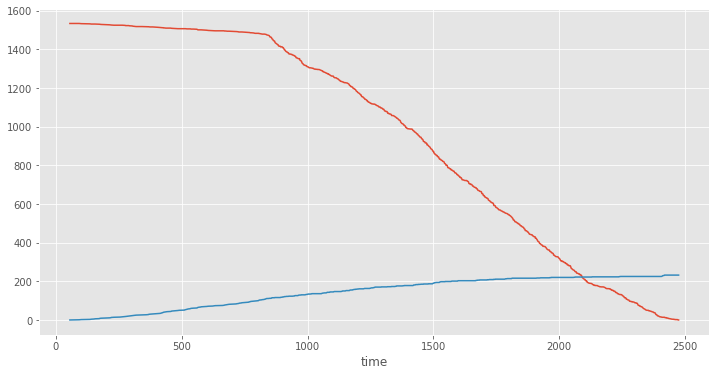

In [519]:
two_groups_gene(df, gene_name)['at-risk1'].plot()
two_groups_gene(df, gene_name)['dead1'].cumsum().plot()

In [516]:
gene_name = 'TADA2A'
dfg = reduce_time_resolution(two_groups_gene(df, gene_name), T)
dfg[65:70]

,at-risk1,at-risk2,dead1,dead2
65,705.0,775.0,0.0,2.0
66,685.0,746.0,4.0,0.0
67,654.0,718.0,1.0,0.0
68,628.0,695.0,2.0,0.0
69,593.0,685.0,1.0,8.0


In [229]:
T = 150

df1 = two_groups_gene(df, gene_name)

Tmin = df1.index.min()
Tmax = df1.index.max()
tt = np.linspace(Tmin, Tmax, T)
dfc = pd.DataFrame()
for t_down, t_up in zip(tt[:1], tt[1:2]):
    dft = df1[(t_down <= df1.index) & (df1.index < t_up)]
    r = dft.sum()[['dead1', 'dead2']]
    r['at-risk1'] = dft['at-risk1'].max()
    r['at-risk2'] = dft['at-risk2'].max()
    dfc = dfc.append(r, ignore_index=True)
dfc.fillna(method='backfill').dropna()

KeyError: 1

In [253]:
dfg = dfg[idc_split]

dft = dfg#.groupby('time').sum()
dft = dft.sort_values('time').reset_index()
dft['total'] = len(dft)
dft['dead'] = dft.event
dft['cum_dead'] = dft.dead.cumsum()

# dft['censored'] = (~dft.event).cumsum()
# incorporate censorship. Change to 'at-risk'
dft['cum_censored'] = (dft.event == 0).cumsum()
dft['at-risk'] = dft['total']
dft.loc[1:,'at-risk'] = dft[1:]['at-risk'] - dft[:-1]['cum_dead'] - dft[:-1]['cum_censored']

<ipython-input-253-ba130468ce7c>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfg = dfg[idc_split]


In [751]:
Ot1

array([-10., -10.,  -7., -10., -10., -10.,  -7., -10.,  -6.,  -5.,  -5.,
       -10., -10.,  -8.,  -6., -14.,  -6.,  -5.,  -6.,  -9., -11., -12.,
       -12.,  -8.,  -7.,  -4., -13.,  -4.,  -9.,  -5.,  -8.,  -4.,  -8.,
       -10., -10.,  -8.,  -5.,  -9.,  -6.,  -5.,  -8.,  -6.,  -6.,  -5.,
        -5.,  -7.,  -9.,  -9.,  -7.,  -3.,  -7.,  -6.,  -4.,  -8.,  -9.,
        -5.,  -5.,  -1.,  -5.,  -5.,  -5.,  -4.,  -4.,  -3.,  -6.,  -2.,
        -1.,  -4.,  -3.,  -3.,  -5.,  -3.,  -7.,  -3.,  -5.,  -5.,  -4.,
         0.,  -5.,  -4.,  -6.,  -5.,  -6.,  -6.,  -3.,  -4.,  -6.,  -7.,
        -4.,  -9.,  -4.,  -1.,  -2.,  -5.,  -2.,  -4.,  -5.,  -3.,  -4.,
        -1.])

In [ ]:


df_disp, dfp = illustrate_survival_curve(df, gene_name, T)
plt.savefig(remote_dir + gene_name + ".png")
plt.show()

dfd = df_disp.copy()
dfd = dfd.iloc[:, :-2]

for tag in ['pvalue', 'pvalue_rev']:
    dfd[tag] = np.round(dfd[tag],3)

for tag in ['at-risk X', 'at-risk Y', 'events X', 'events Y']:
    dfd[tag] = dfd[tag].astype(int)

dfd.index.name = 'time'
    
rm_dir = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/csv/"
dfd.to_csv(rm_dir + f'{gene_name}.csv')


In [125]:
T = 100
N1 = 1000
N2 = 1000
eps = 0.01
mu = 0.05
Nt1, Nt2 = sample_survival_data(T, N1, N2, eps, mu)
evaluate_test_stats(Nt1, Nt2)

{'Logrank': 0.036565641369759184,
 'HC': 19.898989898874632,
 'Fisher': 3.02571473857662,
 'minP': 31.3855699267849,
 'BJ': 46.04514669138503}

In [126]:
log_rank_test(Nt1, Nt2)

(0.036565641369759184, 0.848352102234302)

In [130]:
_log_rank_test(Nt1, Nt2, alternative='two-sided')

(2.2805518191857352, 0.02257498112069625)

In [132]:
dfg

,at-risk1,at-risk2,Group 1,Group 2
time,,,,
56.0,1533.0,1534.0,1.000000,1.000000
93.0,1533.0,1533.0,1.000000,0.999348
101.0,1533.0,1532.0,1.000000,0.998696
136.0,1533.0,1532.0,1.000000,0.998696
141.0,1533.0,1531.0,1.000000,0.998044
...,...,...,...,...
2469.0,1373.0,1374.0,0.895629,0.895698
2472.0,1373.0,1374.0,0.895629,0.895698
2473.0,1373.0,1374.0,0.895629,0.895698


In [59]:
df.time.min()

56.0